In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

Leemos los datos resultantes del notebook de [preprocesamiento](https://github.com/Millan13/Moneyball-NBA/blob/master/Notebooks/Integracion_data.ipynb)

In [2]:
pd.set_option('display.max_columns', 500)
filename = 'df_pairs.csv'
df_pairs = pd.read_csv(filename)
df_pairs

,Unnamed: 0,shooter,assister,team,gametype,season,count
0,0,. Abrines,A. Roberson,OKC,regular,2016-2017,6
1,1,. Abrines,C. Anthony,OKC,regular,2017-2018,8
2,2,. Abrines,C. Payne,OKC,regular,2016-2017,3
3,3,. Abrines,D. Johnson,OKC,regular,2017-2018,3
4,4,. Abrines,D. McDermott,OKC,playoff,2016-2017,1
...,...,...,...,...,...,...,...
26088,26088,Z. Williamson,J. Hayes,NOP,regular,2019-2020,1
26089,26089,Z. Williamson,J. Holiday,NOP,regular,2019-2020,32
26090,26090,Z. Williamson,J. Redick,NOP,regular,2019-2020,2
26091,26091,Z. Williamson,L. Ball,NOP,regular,2019-2020,57


In [3]:
filename2 = 'df_involvement.csv'
df_involvement = pd.read_csv(filename2)
df_involvement

,Unnamed: 0,player,team,gametype,season,shot_involvement
0,0,. Abrines,OKC,playoff,2016-2017,11
1,1,. Abrines,OKC,playoff,2017-2018,7
2,2,. Abrines,OKC,regular,2016-2017,155
3,3,. Abrines,OKC,regular,2017-2018,132
4,4,. Ak,CHI,regular,2017-2018,3
...,...,...,...,...,...,...
2867,2867,Z. Randolph,MEM,regular,2016-2017,340
2868,2868,Z. Randolph,SAC,regular,2017-2018,329
2869,2869,Z. Smith,PHI,regular,2018-2019,18
2870,2870,Z. Smith,PHI,regular,2019-2020,4


Creamos una gráfica para cada equipo, temporada y tipo de juego, y las almacenamos en un diccionario.
Luego, iteramos sobre los tiros en que un par de jugadores se apoyaron para realizar un tiro y los añadimos como aristas.

In [4]:
def draw_network_all(team,season,game_type,df_involvement,df_pairs,size=(9,8), lw=2.5, seed=None, k=None, lc='black'):
    df_inv = df_involvement
    df_shots = df_pairs
    
    temporada_inv = df_inv['season'] == season
    df_inv = df_inv[temporada_inv]
    tipo_juego_inv = df_inv['gametype'] == game_type
    df_inv = df_inv[tipo_juego_inv]
    equipo_inv = df_inv['team'] == team
    df_inv = df_inv[equipo_inv]
    
    temporada_shot = df_shots['season'] == season
    df_shots = df_shots[temporada_shot]
    tipo_juego_shot = df_shots['gametype'] == game_type
    df_shots = df_shots[tipo_juego_shot]
    equipo_shot = df_shots['team'] == team
    df_shots = df_shots[equipo_shot]
    
    unique_teams = list(df_inv['team'].unique())
    networks = {}
    #Creo nodos
    for i in unique_teams:
        networks[i] = nx.Graph()
        players = list(df_inv.loc[df_inv['team']==i, 'player'])
        for player in players:
            networks[i].add_node(player)
    #Creo aristas
    for row in df_shots.itertuples():
        #Get the team and partnership in question
        team = row.team
        player1 = row.shooter
        player2 = row.assister
        shots = row.count

        #Find the appropriate graph and add the weight
        networks[team].add_edge(player1, player2, weight=shots)
    
    #Get the network and remove isolated nodes
    G = networks[team]
    G.remove_nodes_from(list(nx.isolates(G)))
    
    #Get the team color for the nodes
    # ncolor = df_teams.loc[df_teams['CommentName']==team,'TeamColor'].item()
    
    #Calculate the node sizes and the edge weights
    sizes = np.array([df_inv.loc[df_inv['player'] == i,['shot_involvement']].iloc[0].item()
                  for i in G.nodes]) *10 #0 
    #weights = [(G[u][v]['weight']**1.5)*(lw/10) for u,v in G.edges()]
    weights = [(G[u][v]['weight'])*(lw/10) for u,v in G.edges()]
    
    #Draw the plot
    plt.figure(figsize=size)
    nx.draw(G,
            pos=nx.spring_layout(G, k=5.4),
            with_labels=True,
            node_size=sizes,
            # node_color=ncolor,
            width=weights,
            font_weight="bold",
            font_color=lc,
            alpha=.9,
            edge_color="grey")
    title = f'{team} Player Interdependence'
    plt.title(title)
    
    #Declare columns and create a blank dataframe
    cols = ['Team','Degree','Closeness','Betweenness','Eigen','Unweighted','Weighted']
    df_centrality = pd.DataFrame(columns=cols)

    #Iterate through the different teams' networks
    for i in unique_teams:
        temp_G = networks[i]

        #For the team, create dictionaries of what we want
        team = {player:i for player in list(temp_G.nodes)}
        degree = dict(nx.degree(temp_G))
        closeness = {i:nx.closeness_centrality(temp_G, i)
                     for i in temp_G.nodes}
        betweenness = nx.betweenness_centrality(temp_G)
        eigen = nx.eigenvector_centrality(temp_G)


        for u,v,d in temp_G.edges(data=True):
            #...if we have a weight value
            if 'weight' in d:
                #...which is positive
                if d['weight'] != 0:
                    #calculate the reciprocal
                    d['reciprocal'] = 1/d['weight']

                    test1 = nx.betweenness_centrality(temp_G)
                    test2 = nx.betweenness_centrality(temp_G, weight='reciprocal')


        #Create a dataframe
        df_temp = pd.DataFrame([team,degree,closeness,
                               betweenness,eigen,test1,test2]).T
        df_temp.columns = cols

        #Append it to our centrality dataframe
        df_centrality = pd.concat([df_centrality, df_temp])
    return df_centrality

,Team,Degree,Closeness,Betweenness,Eigen,Unweighted,Weighted
C. Frye,CLE,8,0.833333,0.0322222,0.315954,0.0322222,0
D. Jones,CLE,3,0.555556,0,0.128428,0,0
D. Williams,CLE,11,0.909091,0.0842857,0.382359,0.0842857,0.222222
I. Shumpert,CLE,8,0.833333,0.047619,0.314295,0.047619,0
J. Smith,CLE,5,0.625,0.0031746,0.209479,0.0031746,0
K. Irving,CLE,9,0.909091,0.0409524,0.348396,0.0409524,0.422222
K. Korver,CLE,8,0.833333,0.047619,0.314295,0.047619,0
K. Love,CLE,9,0.909091,0.0409524,0.348396,0.0409524,0
L. James,CLE,9,0.909091,0.0409524,0.348396,0.0409524,0.377778
R. Jefferson,CLE,5,0.666667,0,0.221489,0,0


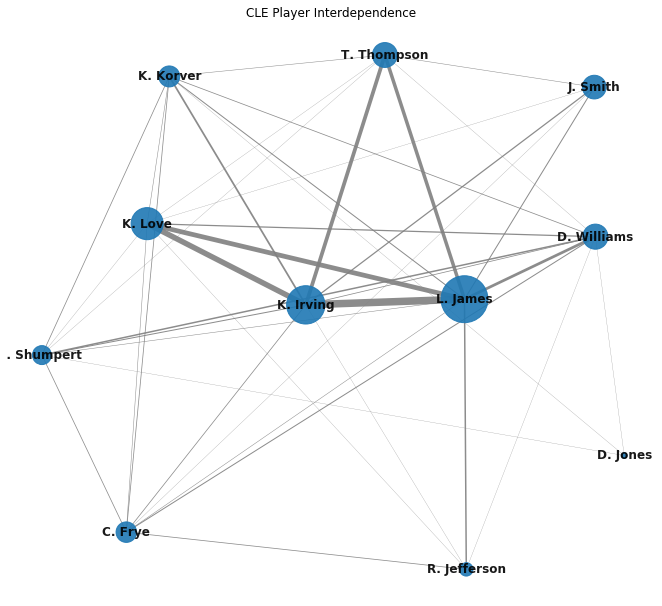

In [5]:
draw_network_all('CLE','2016-2017','playoff',df_involvement,df_pairs)

,Team,Degree,Closeness,Betweenness,Eigen,Unweighted,Weighted
C. Andersen,CLE,8,0.653846,0.000565611,0.154959,0.000565611,0
C. Frye,CLE,14,0.85,0.00706442,0.266698,0.00706442,0
D. Jones,CLE,3,0.548387,0,0.0602948,0,0
D. Liggins,CLE,15,0.894737,0.0149251,0.277578,0.0149251,0
D. Williams,CLE,16,0.85,0.0578517,0.262024,0.0578517,0.0588235
E. Tavares,CLE,3,0.548387,0,0.0626885,0,0
I. Shumpert,CLE,16,0.944444,0.0504643,0.281979,0.0504643,0.0110294
J. Jones,CLE,14,0.85,0.0391749,0.250277,0.0391749,0.00735294
J. McRae,CLE,12,0.772727,0.00584158,0.227648,0.00584158,0
J. Smith,CLE,11,0.73913,0.00207219,0.216005,0.00207219,0


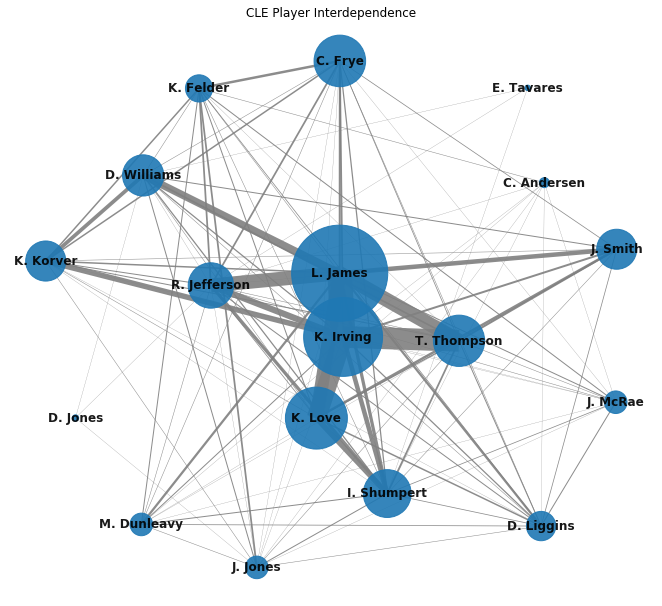

In [6]:
draw_network_all('CLE','2016-2017','regular',df_involvement,df_pairs)

,Team,Degree,Closeness,Betweenness,Eigen,Unweighted,Weighted
A. ii,CLE,3,0.571429,0.00252525,0.0881877,0.00252525,0
C. Osman,CLE,6,0.666667,0.00420875,0.200248,0.00420875,0
G. Hill,CLE,8,0.75,0.003367,0.270055,0.003367,0
J. Caldern,CLE,8,0.75,0.0451178,0.238273,0.0451178,0
J. Clarkson,CLE,8,0.75,0.0412458,0.247525,0.0412458,0
J. Green,CLE,11,0.923077,0.0324435,0.337863,0.0324435,0
J. Smith,CLE,9,0.8,0.0161135,0.286615,0.0161135,0
K. Korver,CLE,9,0.8,0.0109428,0.293606,0.0109428,0
K. Love,CLE,9,0.8,0.00769601,0.29452,0.00769601,0
L. James,CLE,11,0.923077,0.0324435,0.337863,0.0324435,0.772727


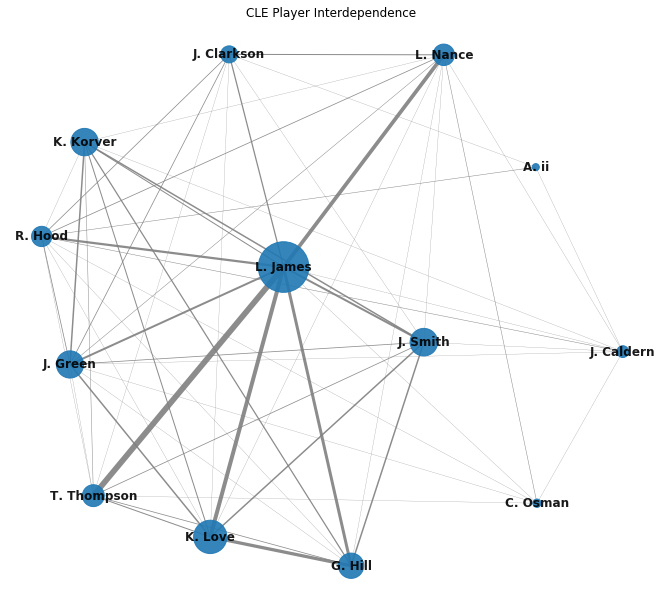

In [7]:
draw_network_all('CLE','2017-2018','playoff',df_involvement,df_pairs)

,Team,Degree,Closeness,Betweenness,Eigen,Unweighted,Weighted
A. ii,CLE,11,0.677419,0.0993651,0.165402,0.0993651,0.0952381
C. Frye,CLE,13,0.7,0.00409692,0.210281,0.00409692,0
C. Osman,CLE,18,0.875,0.0451891,0.263356,0.0451891,0.0047619
D. Rose,CLE,10,0.636364,0.000829726,0.172358,0.000829726,0
D. Wade,CLE,13,0.724138,0.0126891,0.204029,0.0126891,0.142857
G. Hill,CLE,12,0.677419,0.00261544,0.198039,0.00261544,0.0714286
I. Shumpert,CLE,11,0.65625,0.000829726,0.189354,0.000829726,0
I. Thomas,CLE,9,0.617647,0,0.153219,0,0
J. Caldern,CLE,18,0.875,0.0472207,0.26267,0.0472207,0.0619048
J. Clarkson,CLE,13,0.724138,0.00674242,0.20867,0.00674242,0.0047619


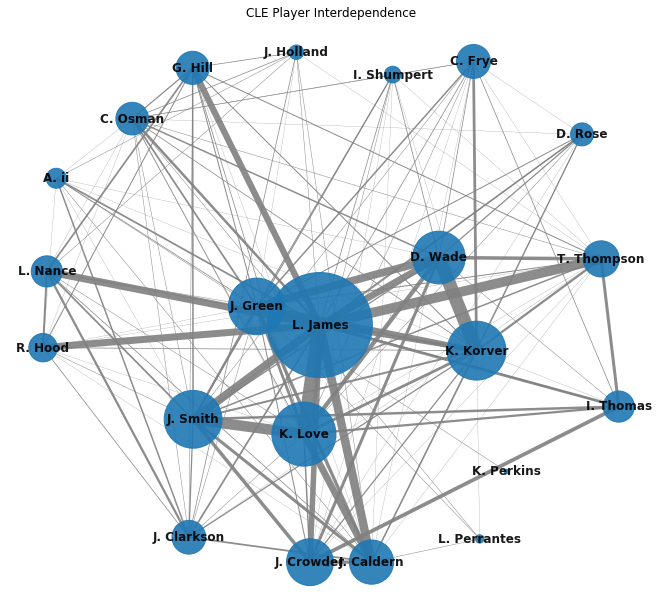

In [8]:
draw_network_all('CLE','2017-2018','regular',df_involvement,df_pairs)

,Team,Degree,Closeness,Betweenness,Eigen,Unweighted,Weighted
A. Burks,CLE,15,0.727273,0.0619006,0.204198,0.0619006,0.161232
A. Harrison,CLE,8,0.6,0.00144043,0.124192,0.00144043,0
A. Zizic,CLE,17,0.774194,0.0255636,0.229191,0.0255636,0
B. Knight,CLE,13,0.666667,0.00523781,0.190448,0.00523781,0.0652174
C. Frye,CLE,15,0.727273,0.0192604,0.203118,0.0192604,0
C. Osman,CLE,21,0.888889,0.0497686,0.270849,0.0497686,0.199275
C. Payne,CLE,8,0.6,0.00228188,0.117911,0.00228188,0
C. Sexton,CLE,21,0.888889,0.0452149,0.27461,0.0452149,0.309783
D. Adel,CLE,9,0.6,0.000872859,0.143144,0.000872859,0
D. Nwaba,CLE,19,0.827586,0.0308963,0.254607,0.0308963,0


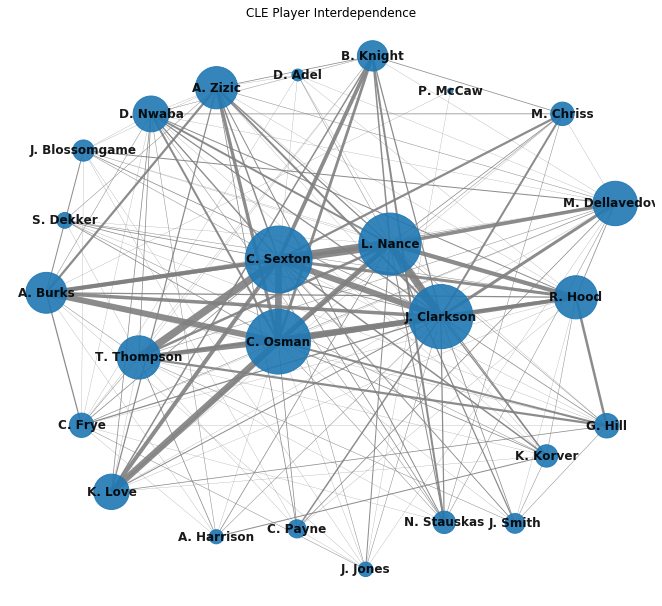

In [9]:
draw_network_all('CLE','2018-2019','regular',df_involvement,df_pairs) #no hay playoffs en 18-19

,Team,Degree,Closeness,Betweenness,Eigen,Unweighted,Weighted
A. Iguodala,GSW,11,0.866667,0.0349512,0.330622,0.0349512,0
D. Green,GSW,11,0.866667,0.0349512,0.330622,0.0349512,0.487179
D. Jones,GSW,2,0.52,0.00213675,0.0514585,0.00213675,0
D. West,GSW,9,0.764706,0.0173077,0.282762,0.0173077,0.0128205
I. Clark,GSW,10,0.8125,0.0463675,0.295436,0.0463675,0.0128205
J. McAdoo,GSW,5,0.619048,0.00747863,0.143201,0.00747863,0
J. McGee,GSW,7,0.684211,0.00160256,0.235183,0.00160256,0
K. Durant,GSW,10,0.8125,0.0178571,0.312051,0.0178571,0.269231
K. Thompson,GSW,10,0.8125,0.0178571,0.312051,0.0178571,0
M. Barnes,GSW,7,0.684211,0.0592949,0.189774,0.0592949,0.025641


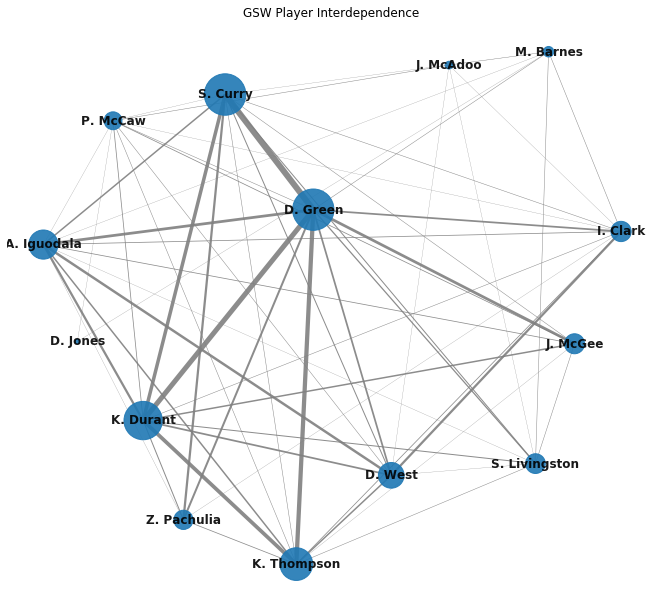

In [10]:
draw_network_all('GSW','2016-2017','playoff',df_involvement,df_pairs)

,Team,Degree,Closeness,Betweenness,Eigen,Unweighted,Weighted
A. Iguodala,GSW,14,0.888889,0.0238763,0.270972,0.0238763,0.0916667
A. Varejo,GSW,6,0.615385,0,0.129199,0,0
B. Weber,GSW,4,0.571429,0,0.087795,0,0
D. Green,GSW,13,0.842105,0.00304293,0.264645,0.00304293,0.491667
D. Jones,GSW,4,0.571429,0,0.0865022,0,0
D. West,GSW,11,0.761905,0.000694444,0.229728,0.000694444,0
I. Clark,GSW,16,1,0.0651263,0.286516,0.0651263,0.304167
J. McAdoo,GSW,13,0.842105,0.020202,0.254324,0.020202,0
J. McGee,GSW,11,0.761905,0.000694444,0.230215,0.000694444,0
K. Durant,GSW,13,0.842105,0.0120707,0.256215,0.0120707,0.0833333


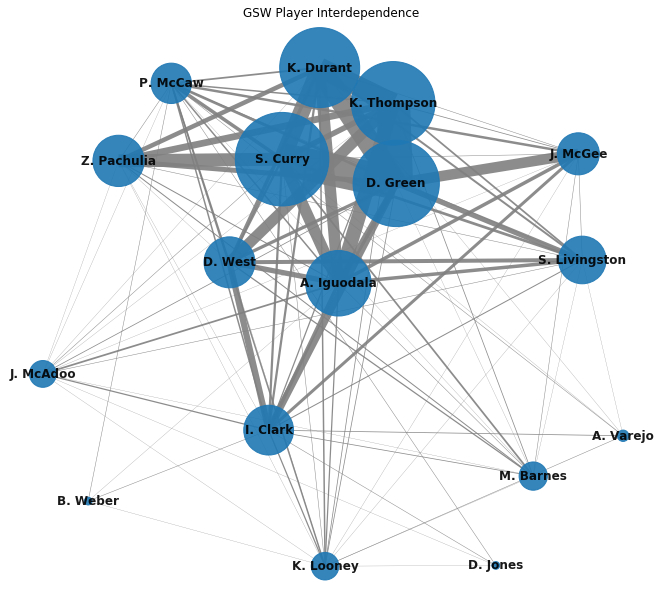

In [11]:
draw_network_all('GSW','2016-2017','regular',df_involvement,df_pairs)

,Team,Degree,Closeness,Betweenness,Eigen,Unweighted,Weighted
. Abrines,OKC,15,0.857143,0.0227254,0.275132,0.0227254,0
A. Morrow,OKC,11,0.72,0.00392935,0.220425,0.00392935,0
A. Roberson,OKC,14,0.818182,0.0185704,0.260862,0.0185704,0
C. Payne,OKC,8,0.62069,0.00718954,0.14796,0.00718954,0.117647
D. McDermott,OKC,12,0.75,0.00719732,0.230762,0.00719732,0
D. Sabonis,OKC,13,0.782609,0.00853045,0.251166,0.00853045,0.0490196
E. Kanter,OKC,15,0.857143,0.0227254,0.275132,0.0227254,0.222222
E. lyasova,OKC,2,0.514286,0,0.0431435,0,0
J. Grant,OKC,17,0.947368,0.0478966,0.294512,0.0478966,0.0130719
J. Huestis,OKC,5,0.580645,0.00245098,0.0997935,0.00245098,0


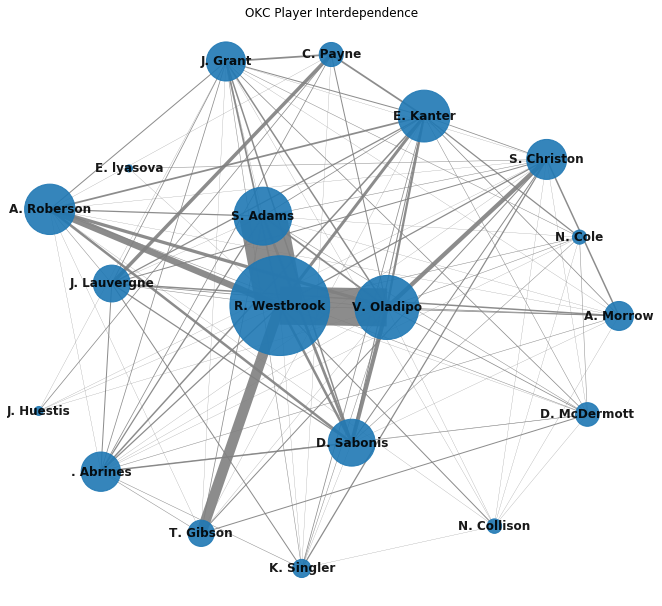

In [12]:
draw_network_all('OKC','2016-2017','regular',df_involvement,df_pairs)